In [ ]:
from keras import layers, models, callbacks
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models

import requests
from io import BytesIO

In [6]:
df = pd.read_csv('albums_genres_grouped.csv')

In [ ]:
from itertools import chain
GENRE_KEYWORDS = [
    "pop", "rock", "rap", "hip hop", "trap", "country", "metal", "r&b", 
    "jazz", "indie", "electronic", "house", "techno", "reggae", "folk", 
    "funk", "soul", "punk", "blues", "alternative", "classical", "ambient", 
    "k-pop", "kids", "afrobeats","relaxed","latin"
]

# Group tags by canonical genre
GENRE_GROUPS = {
    "rock": [
        "psychedelic", "post-rock", "post-grunge", "grunge", "shoegaze", "canadian"
    ],
    "pop": [
        "female vocalist", "female vocalists", "5 seconds of summer", "synthpop", 
        "tatemcrae", "my top songs", "sexy", "bee gees", "hyperpop", "digital tendencies",
        "2-step", "acoustic", "comedy", "singer-songwriter", "3", "disco", "wedding",
        "30", "peter", "midnights", "poptron", "doo-wop", "male vocals", "new wave", 
        "later", "joaoaksnes", "madonna", "portals", "aoty", "mayhem", "guts", 
        "short n' sweet", "soty", "cypriot", "breakbeat", "chinese", "german",
        "absolute bangers", "danish", "azerbaijan", "hardstyle", "japanese", "argentina",
        "indian", "india", "bhangra", "nigeria", "bollywood", "italian", "morocco",
        "traditional", "ukrainian"
    ],
    "latin": [
        "puerto rico", "mexico", "sad sierreno", "lada del 602", "corridos tumbados", 
        "seen live", "ramito de violeta", "chickencore", "corona", "cuck", "luar la l",
        "peso pluma", "spanish", "bachata", "salsa", "mierda", "banda", "duranguense",
        "romantico grupero", "colombia", "drum and bass", "sertanejo", "pagode", 
        "samba", "corrido tumbado", "mexican", "spain"
    ],
    "relaxed": [
        "ambient", "sleep", "reiki", "instrumental", "lo-fi", "rain", "nature sounds",
        "chill", "nature", "noise", "eargasm", "chillout", "white noise", "piano", 
        "hindi"
    ],
    "rap": [
        "harder than diamonds", "peak", "drill", "heavy", "my scribbled", "drake", 
        "baby keem", "g59", "j cole", "tag lil tecca-lot of me", "kanye wes", "bronx drill",
        "transitions", "auto-tagged", "gunna", "mumble crap", "boom bap", "quirky", 
        "underrated", "phonk", "chipmunk soul", "diss", "worst album ever", "nitrous", 
        "juggin", "4 out of 5", "czech", "sematary grave man from the haunted mound real nazgul skincarver keeper of da trees haunted mound lord",
        "grime", "juice wrld", "polo g", "lil uzi vert", "kanye west"
    ],
    "reggae": [
        "reggaeton", "party", "dancehall", "love"
    ],
    "hip hop": [
        "linedance", "nice", "florida", "don toliver", "southern hip-hop", "dr congo", 
        "mother", "sampling", "plugg", "ebm", "egyptian", "a cappella", "ghana", 
        "cumbia 420", "hip-hop", "melodic hip-hop"
    ],
    "metal": [
        "metalcore", "progressive metalcore", "rage", "post-hardcore", "demonic"
    ],
    "r&b": [
        "rnb", "aggressive", "king billionheir", "love at first listen", "personal favourites", 
        "sza", "british", "3 out of 5", "steve lacy"
    ],
    "k-pop": [
        "bts", "kpop", "korean", "jersey club", "it boy global"
    ],
    "religious": [
        "christian", "ccm", "worship", "gospel", "musiclist", "experimental", "hariharan", "thai"
    ],
    "electronic": [
        "depressive", "indietronica", "synthwave", "childish gamblingo", "featuring", 
        "trance", "ass", "downtempo", "dance", "60s", "polish", "russian", "norway", 
        "eurodance", "remix", "frenchcore", "uk garage"
    ],
    "indie": [
        "songs i crank my hog to", "bossa nova", "wsum 91.7 fm madison", 
        "songs i like to play whilst walking down the street at night music", 
        "gambling addiction", "emo", "darkwave", "slowcore", "stolen", "life changing", 
        "vinyl", "gothangelz", "ai", "ukranian", "opm"
    ],
    "afrobeats": [
        "afrobeats", "kenyan"
    ],
    "country": [
        "usa", "fearless", "linedance 2021", "texas", "feel good", "furry", 
        "linedance catalan", "american", "haunted", "linedance 2022"
    ],
    "kids": [
        "soundtrack", "video game music", "australian", "disney", "musical", "infantil"
    ],
    "trap": [
        "detroit trap"
    ],
    "funk": [
        "brazil"
    ],
    "folk": [
        "arabic"
    ]
}
# Flatten genre groupings into a mapping
MANUAL_GENRE_MAP = {
    tag: genre
    for genre, tags in GENRE_GROUPS.items()
    for tag in tags
}


def map_to_final_genre(genre_str):
    genre_str_lower = str(genre_str).strip().lower()
    
    # Check canonical match
    for genre in GENRE_KEYWORDS:
        if genre in genre_str_lower:
            return genre

    # Check exact match in manual mapping
    if genre_str_lower in MANUAL_GENRE_MAP:
        return MANUAL_GENRE_MAP[genre_str_lower]

    # Return as-is if not matched
    return genre_str_lower

# Apply to your DataFrame
df['genre_cleaned'] = df['genre'].apply(map_to_final_genre)


In [61]:
df["genre_cleaned"].unique()

array(['relaxed', 'folk', 'country', 'rap', 'pop', 'r&b', 'hip hop',
       'rock', 'indie', 'reggae', 'unknown', 'latin', 'electronic',
       'soul', 'metal', 'jazz', 'religious', 'k-pop', 'funk', 'kids'],
      dtype=object)

In [62]:
df = pd.read_csv("albums_genres_grouped.csv")
genre_map = {
    'hip hop': 'rap/hip hop',
    'rap': 'rap/hip hop',
    'soul': 'soul/jazz',
    'funk': 'soul/jazz',
    'jazz': 'soul/jazz',
    'folk': 'country/folk',
    'country': 'country/folk'
}

# Apply the mapping
df['genre_condensed'] = df['genre_cleaned'].replace(genre_map)
df.to_csv('albums_genres_grouped.csv', index=False)

In [ ]:
df = pd.read_csv("albums_genres_grouped.csv")

img_dir = "../album_images"
df['filepath'] = df['album_id'].apply(lambda x: os.path.join(img_dir, (x + '.jpg')))
df = df[df['filepath'].apply(os.path.exists)]  # Drop missing files

,album_id,album_name,artist_name,release_date,total_tracks,popularity,image_url,genre,genre_cleaned,filepath
0,0NGHR9zjS5eFFlqtClA9VV,Best White Noise For Sleeping Baby,Dream Supplier,2020-04-29,6,86,https://i.scdn.co/image/ab67616d0000b273f036cf...,ambient,relaxed,../album_images/0NGHR9zjS5eFFlqtClA9VV.jpg
1,2fenSS68JI1h4Fo296JfGr,folklore,Taylor Swift,2020-07-24,16,85,https://i.scdn.co/image/ab67616d0000b27395f754...,folk,folk,../album_images/2fenSS68JI1h4Fo296JfGr.jpg
2,0sOeI7pbAmIc8aDFyvkBUW,Starting Over,Chris Stapleton,2020-11-13,14,79,https://i.scdn.co/image/ab67616d0000b273940834...,country,country,../album_images/0sOeI7pbAmIc8aDFyvkBUW.jpg
3,6n9DKpOxwifT5hOXtgLZSL,Legends Never Die,Juice WRLD,2020-07-10,22,80,https://i.scdn.co/image/ab67616d0000b2733e0698...,juice wrld,rap,../album_images/6n9DKpOxwifT5hOXtgLZSL.jpg
4,2QRedhP5RmKJiJ1i8VgDGR,Whole Lotta Red,Playboi Carti,2020-12-25,24,81,https://i.scdn.co/image/ab67616d0000b27398ea0e...,trap,rap,../album_images/2QRedhP5RmKJiJ1i8VgDGR.jpg
...,...,...,...,...,...,...,...,...,...,...
1495,1FNlyaODRZdBnUIoApApdy,СПАСИ И ПОТУСИ,GSPD,2025-04-04,1,0,https://i.scdn.co/image/ab67616d0000b27387e426...,russian,electronic,../album_images/1FNlyaODRZdBnUIoApApdy.jpg
1496,3XlIAm2aT2MAfpmAuBjH5S,Intergalactic Dreams,Niphkeys,2025-04-03,8,0,https://i.scdn.co/image/ab67616d0000b273874637...,nigeria,pop,../album_images/3XlIAm2aT2MAfpmAuBjH5S.jpg
1497,5ESO6fmtHcFaKYDKuWurIu,Déjà-vu,GREGO,2025-04-04,1,0,https://i.scdn.co/image/ab67616d0000b2735ed640...,traditional,pop,../album_images/5ESO6fmtHcFaKYDKuWurIu.jpg
1498,1xpLTob6cmxhEAMalVmDCA,Ватсап (Remake 2025),VESNA305,2025-04-04,1,0,https://i.scdn.co/image/ab67616d0000b273751c57...,pop,pop,../album_images/1xpLTob6cmxhEAMalVmDCA.jpg


In [ ]:
# Setup
image_folder = "../album_images"
image_size = (64, 64)  # Or whatever your CNN input expects (e.g., 64x64)

# Choose the label column ('genre' or 'popularity')
label_column = 'popularity'  # or 'popularity'

# Filter for images that actually exist
df = pd.read_csv("albums_genres_grouped.csv")
df = df[df['album_id'].apply(lambda x: os.path.isfile(os.path.join(image_folder, f"{x}.jpg")))]

# Initialize lists
X = []
y = []

# Load and label
for _, row in df.iterrows():
    image_path = os.path.join(image_folder, f"{row['album_id']}.jpg")
    try:
        img = Image.open(image_path).resize(image_size)
        img_array = np.array(img) / 255.0  # Normalize to [0,1]
        X.append(img_array)
        y.append(row[label_column])
    except Exception as e:
        print(f"Error loading {image_path}: {e}")

X = np.array(X)
y = np.array(y)



In [ ]:
# Wrap into tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((X, y))

# Shuffle, batch, prefetch
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

# Optional: split manually (or use sklearn's train_test_split earlier)
train_size = int(0.8 * len(X))
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

train_dataset = (
    train_dataset
    .shuffle(buffer_size=1000)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

val_dataset = (
    val_dataset
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def preprocess(image, label):
    image = data_augmentation(image)
    return image, label

train_dataset = train_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)


In [ ]:
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Flatten + Dense
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))  # Single output for regression

callback = callbacks.EarlyStopping(monitor='loss', patience=1, verbose=1)

# Compile
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

model.summary()

model.fit(train_dataset, validation_data=val_dataset, epochs=20)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 646,273 (2.47 MB)

 Trainable params: 646,273 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 2107.1001 - mean_absolute_error: 39.4192 - val_loss: 5738.1685 - val_mean_absolute_error: 69.1249
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 207.1096 - mean_absolute_error: 11.5320 - val_loss: 4748.3110 - val_mean_absolute_error: 63.0212
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 108.3527 - mean_absolute_error: 8.1819 - val_loss: 4553.4985 - val_mean_absolute_error: 61.8305
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 81.3858 - mean_absolute_error: 7.1180 - val_loss: 4321.3936 - val_mean_absolute_error: 60.2920
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 68.9971 - mean_absolute_error: 6.5166 - val_loss: 4543.7783 - val_mean_absolute_error: 61.9172
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 64.1421 - mean_absolute_error: 6.3380 - val_loss: 4788.2734 - val_mean_absolute_error: 63.7941
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 79.8359 - m

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


2025-04-16 13:24:54.708407: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


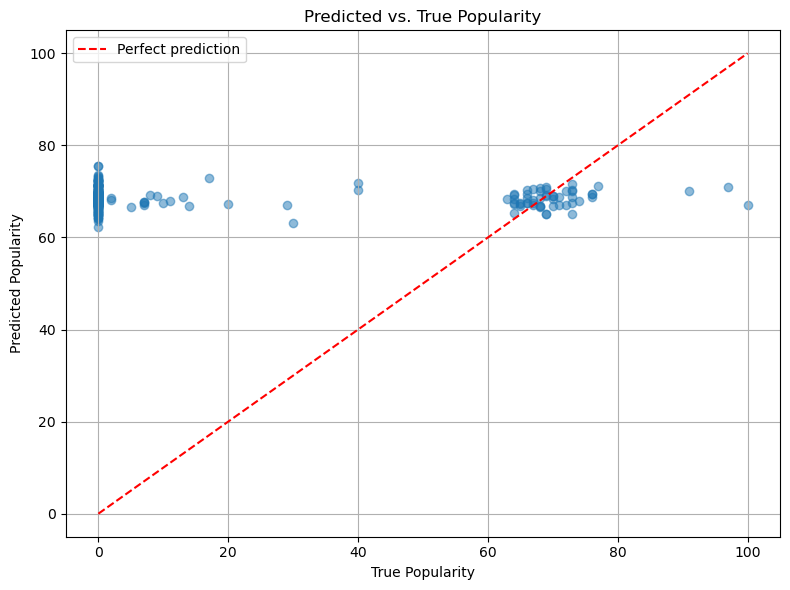

In [41]:
# Extract true labels and images from the validation dataset
y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_pred.extend(preds.flatten())
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)


plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Perfect prediction')
plt.xlabel("True Popularity")
plt.ylabel("Predicted Popularity")
plt.title("Predicted vs. True Popularity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [63]:
# Setup
df = pd.read_csv("albums_genres_grouped.csv")
image_folder = "../album_images"
image_size = (64, 64)

le = LabelEncoder()
df['genre_cleaned_label'] = le.fit_transform(df['genre_cleaned'])
n_classes = len(le.classes_)

# Filter for images that actually exist
df = df[df['album_id'].apply(lambda x: os.path.isfile(os.path.join(image_folder, f"{x}.jpg")))]

# Initialize lists
X = []
y = []

# Load and label
for _, row in df.iterrows():
    image_path = os.path.join(image_folder, f"{row['album_id']}.jpg")
    try:
        img = Image.open(image_path).resize(image_size)
        img_array = np.array(img) / 255.0  # Normalize to [0,1]
        X.append(img_array)
        y.append(row['genre_cleaned_label'])
    except Exception as e:
        print(f"Error loading {image_path}: {e}")

X = np.array(X)
y = np.array(y)

In [66]:
# Split your data first (recommended)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# One-hot encode the labels (before creating the dataset)
y_train = to_categorical(y_train, num_classes=n_classes)
y_val = to_categorical(y_val, num_classes=n_classes)

# Wrap in tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Set batch size and autotune
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

# Optional data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Preprocessing function
def preprocess(image, label):
    image = data_augmentation(image)
    return image, label

# Apply augmentation only to training data
train_dataset = (
    train_dataset
    .shuffle(buffer_size=1000)
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

val_dataset = (
    val_dataset
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)


In [67]:

# CNN architecture (same structure, updated input/output)
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Dense layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(n_classes, activation='softmax'))  # Multi-class output

model.summary()

# Early stopping (optional)
callback = callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[callback]
)

/opt/anaconda3/envs/dsan6600/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 647,508 (2.47 MB)

 Trainable params: 647,508 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.1336 - loss: 2.8211 - val_accuracy: 0.1800 - val_loss: 2.6837
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1876 - loss: 2.6776 - val_accuracy: 0.1900 - val_loss: 2.6889
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1794 - loss: 2.6321 - val_accuracy: 0.2000 - val_loss: 2.6348
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1909 - loss: 2.6103 - val_accuracy: 0.2000 - val_loss: 2.6134
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1980 - loss: 2.6321 - val_accuracy: 0.2000 - val_loss: 2.6041
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1870 - loss: 2.6073 - val_accuracy: 0.2100 - val_loss: 2.6233
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1972 - loss: 2.6005 - val_accuracy: 0.1967 - val_loss: 2.5852
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.2188 - loss: 2.5707 - val_accuracy: 0.2167 - v